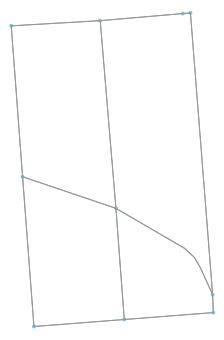

(<Figure size 352.069x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4d3d6ac588>)

In [167]:
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, Polygon, LineString

# get osm graph

# get bbox bounds: 

north = 37.7599 # max lat 
south = 37.7569 # min lat

east = -122.3997 # max lng
west = -122.4023 # min lng 
 
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

# G_projected = ox.project_graph(G)
# ox.plot_graph(G_projected)

ox.plot_graph(G)


In [180]:
# explore graph 

basic_stats = ox.basic_stats(G)
    
print("\n n (number of nodes in the graph):", basic_stats['n'])
print("\n m (number of edges in the graph):", basic_stats['m']/2) # because it's an undirected graph

print("\n street_length_total (sum in meters):", basic_stats['street_length_total'])



 n (number of nodes in the graph): 10

 m (number of edges in the graph): 13.0

 street_length_total (sum in meters): 1420.966


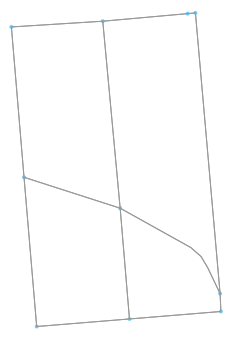

node attributes
Index(['osmid', 'x', 'y', 'geometry'], dtype='object')
edge attributes
Index(['geometry', 'highway', 'key', 'length', 'name', 'oneway', 'osmid', 'u',
       'v'],
      dtype='object')


,geometry,highway,key,length,name,oneway,osmid,u,v
0,"LINESTRING (-122.4020923 37.7596792, -122.4019...",residential,0,143.868,Rhode Island Street,False,84805680,65294613,65294615
1,"LINESTRING (-122.4020923 37.7596792, -122.4011...",residential,0,84.738,20th Street,False,224384045,65294613,65320188
2,"LINESTRING (-122.4019697 37.758389, -122.40096...",residential,0,93.711,Southern Heights Avenue,False,8919494,65294615,65320191
3,"LINESTRING (-122.4019697 37.758389, -122.40184...",residential,0,142.851,Rhode Island Street,False,84805680,65294615,65294616
4,"LINESTRING (-122.4019697 37.758389, -122.40209...",residential,0,143.868,Rhode Island Street,False,84805680,65294615,65294613
5,"LINESTRING (-122.4018467 37.757108, -122.40086...",residential,0,86.158,22nd Street,False,28669973,65294616,65320193
6,"LINESTRING (-122.4018467 37.757108, -122.40196...",residential,0,142.851,Rhode Island Street,False,84805680,65294616,65294615
7,"LINESTRING (-122.40096 37.7581188, -122.401969...",residential,0,93.711,Southern Heights Avenue,False,8919494,65320191,65294615
8,"LINESTRING (-122.40096 37.7581188, -122.400869...",residential,0,106.023,De Haro Street,False,224384013,65320191,65320193
9,"LINESTRING (-122.40096 37.7581188, -122.40113 ...",residential,0,179.060,De Haro Street,False,224384013,65320191,65320188


In [178]:
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

nodes, edges = ox.graph_to_gdfs(G) # make two dataframes - one for nodes and one for edges

print("node attributes")
print(nodes.columns)

print("edge attributes")
print(edges.columns)

# NODES
# curr_node = nodes.loc[nodes['osmid'] == 65294613] # look up info for the node with id 65294613

# print("geometry")
# print(curr_node.geometry)

# print("\ngeom type")
# print(curr_node.geom_type)

# print("\nx")
# print(curr_node.x)

# print("\ny")
# print(curr_node.y)


# EDGES
# curr_edge = edges.loc[edges['osmid'] == 84805680] # look up info for the node with id 65294613

# print("geometry")
# print(curr_edge.geometry)

# print("\ngeom type")
# print(curr_edge.geom_type)

# print("\nu:", curr_edge.u)
# print("\nv:", curr_edge.v)

# note that u and v are nodes 

# curr_edge.geometry.values[0]


edges

In [208]:
# find odd nodes 

# figure out how many edges, (u,v) pairs, include each node   

nodes_dict = {}


for node in G.nodes:
    nodes_dict[node] = set()
    
# print(len(nodes_dict.keys())) # should = basic_stats['m']/2 because basic stats thinks it's undirected 

# node and edges dataframes
nodes, edges = ox.graph_to_gdfs(G)

edge_counter = 0

for edge in G.edges:
    
    start_node = edge[0]
    end_node = edge[1]
    
    edge = (start_node, end_node) # name edge by start and end node 
    
    # u is start node 
    # v is end node 
    
    curr_edge = edges.loc[(edges['u'] == start_node) & (edges['v'] == end_node)]
    
    way_id = curr_edge.osmid.values[0]
            
    #     print("\nstart:", start_node)
    #     print("start check:", curr_edge.u.values[0])
    
    # add tuple of (start_node, end_node, edge osmid) to the node     
    edge_identifier = (start_node, end_node)
    nodes_dict[start_node].add(edge_identifier)

    # nodes_dict[end_node].add(edge_identifier) # not necessary because we're looping thru each edge twice
    edge_counter += 1


odd_nodes = []

for node in nodes_dict:
    edge_count = len(nodes_dict[node])
    if edge_count % 2 != 0:
        # compile list of odd nodes 
        print("\nnode:", node)
        # print("edges:", nodes_dict[node])
        print("edge_count:", edge_count)
        odd_nodes.append(node)

print(odd_nodes)
# nx.draw(G, with_labels=True, font_weight='bold')



node: 65294615
edge_count: 3

node: 65320193
edge_count: 3

node: 65313455
edge_count: 3

node: 65320188
edge_count: 3
[65294615, 65320193, 65313455, 65320188]


In [244]:
# find ways to connect odd nodes

# each option list should be len(odd_node)/2 long

# if the new option list's first n-1 pairs are the same as an existing list, scrap it

# print(odd_nodes)
items = ['A','B','C','D']

# op_1 = [(A,B), (C,D)] 
# op_2 = [(A,C), (B,D)]
# op_3 = [(A,D), (B,C)]
# op_4 = [(B,C), (A,D)] # same as op3
# op_5 = [(B,D), (A,C)] # same as op2
# op_6 = [(C,D), (A,B)] # same as op1

all_possible_combos = []

index = 0 

while index < len(items):
    # make pair of current item and all others
    print(items[index], items[index+1])
    index += 1

pair1 = set(('A','B'))

pair2 = set(('C','D'))

pair2 = set(('B','A'))

new_set = set()

pair1_t = tuple(pair1)
pair2_t = tuple(pair2)

new_set.add(pair1_t)
new_set.add(pair2_t)

print(new_set)

# each tuple can make a pair with 



A B
B C
C D


IndexError: list index out of range

In [ ]:
nodes_list = list(G.nodes)
edges_list = list(G.edges)

cleaned_edges_list = []

# build a new graph from list of edges and nodes (just to label visual)

G_new = nx.MultiGraph()

G_new.add_nodes_from(nodes_list)

G_new.add_edges_from(edges_list)


for e in G_new.edges(data=True):
    e[2]['distance'] = 5

nx.draw(G_new, with_labels=True)